In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow, imsave

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
MODEL_NAME = 'TerrainGAN_COLAB'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS_DIR = "/content/drive/MyDrive/Weights"
G_WEIGHT_PATH = os.path.join(WEIGHTS_DIR, "G.pkl")
D_WEIGHT_PATH = os.path.join(WEIGHTS_DIR, "D.pkl")
BATCH_SIZE = 64
IMAGE_SIZE = 128
N_NOISE = 100
MAX_EPOCH = 50
N_CRITIC = 2  # discriminator steps per generator step

print(DEVICE)


cuda


In [3]:
DATA_PATH = "/content/dataset/Users/mshestopalov/Datasets/processed_dataset_less_water"
tar_path = "/content/drive/MyDrive/Datasets/processed_dataset_less_water.tar.gz"
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)
!tar -xzf "$tar_path" -C "$extract_path"
os.makedirs(DATA_PATH, exist_ok=True)
!ls /content/dataset/Users/mshestopalov/Datasets/processed_dataset_less_water

Выходные данные были обрезаны до нескольких последних строк (5000).
0240_h_crop21_h.png  1843_h_crop33_h.png  3502_h_crop4_h.png
0240_h_crop22_h.png  1843_h_crop34_h.png  3503_h_crop0_h.png
0240_h_crop23_h.png  1843_h_crop35_h.png  3503_h_crop1_h.png
0240_h_crop24_h.png  1843_h_crop36_h.png  3503_h_crop2_h.png
0240_h_crop25_h.png  1843_h_crop37_h.png  3503_h_crop3_h.png
0240_h_crop26_h.png  1843_h_crop38_h.png  3503_h_crop4_h.png
0240_h_crop27_h.png  1843_h_crop39_h.png  3503_h_crop5_h.png
0240_h_crop28_h.png  1843_h_crop3_h.png   3504_h_crop0_h.png
0240_h_crop29_h.png  1843_h_crop40_h.png  3504_h_crop10_h.png
0240_h_crop2_h.png   1843_h_crop41_h.png  3504_h_crop11_h.png
0240_h_crop30_h.png  1843_h_crop42_h.png  3504_h_crop12_h.png
0240_h_crop31_h.png  1843_h_crop43_h.png  3504_h_crop13_h.png
0240_h_crop32_h.png  1843_h_crop44_h.png  3504_h_crop14_h.png
0240_h_crop33_h.png  1843_h_crop45_h.png  3504_h_crop15_h.png
0240_h_crop34_h.png  1843_h_crop46_h.png  3504_h_crop16_h.png
0240_h_cro

In [4]:
def get_sample_image(G, n_noise):
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, IMAGE_SIZE, IMAGE_SIZE)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([IMAGE_SIZE*10, IMAGE_SIZE*10])
    for j in range(10):
        img[j*IMAGE_SIZE:(j+1)*IMAGE_SIZE] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img


In [5]:
class TerrainDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith("_h.png")]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image


In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_size=IMAGE_SIZE*IMAGE_SIZE):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, input_size=100, output_size=IMAGE_SIZE*IMAGE_SIZE):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), 1, IMAGE_SIZE, IMAGE_SIZE)


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = TerrainDataset(root_dir=DATA_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [8]:
D = Discriminator().to(DEVICE)
G = Generator(N_NOISE).to(DEVICE)

if os.path.exists(D_WEIGHT_PATH) and os.path.exists(G_WEIGHT_PATH):
    D.load_state_dict(torch.load(D_WEIGHT_PATH, map_location=DEVICE))
    G.load_state_dict(torch.load(G_WEIGHT_PATH, map_location=DEVICE))
    print("Loaded pretrained weights from Google Drive.")
else:
    print("No pretrained weights found, starting from scratch.")

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels
real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

# Create samples folder
os.makedirs('samples', exist_ok=True)


Loaded pretrained weights from Google Drive.


In [9]:
step = 0
for epoch in range(MAX_EPOCH):
    for images in dataloader:
        images = images.to(DEVICE)

        # --- Train Discriminator ---
        D_real = D(images)
        D_real_loss = criterion(D_real, real_labels)

        z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)
        D_fake = D(G(z))
        D_fake_loss = criterion(D_fake, fake_labels)

        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # --- Train Generator ---
        if step % N_CRITIC == 0:
            z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)
            G_fake = D(G(z))
            G_loss = criterion(G_fake, real_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # Logging
        if step % 500 == 0:
            print(f"Epoch [{epoch}/{MAX_EPOCH}], Step {step}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

        # Save sample images
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, N_NOISE)
            imsave(f'samples/{MODEL_NAME}_step{step:03d}.jpg', img, cmap='gray')
            G.train()

        step += 1

    # Save weights at the end of each epoch
    torch.save(D.state_dict(), D_WEIGHT_PATH)
    torch.save(G.state_dict(), G_WEIGHT_PATH)
    print(f"Epoch {epoch} completed. Weights saved to Google Drive.")


Epoch [0/50], Step 0, D Loss: 0.4293, G Loss: 2.5551
Epoch 0 completed. Weights saved to Google Drive.
Epoch [1/50], Step 500, D Loss: 0.4225, G Loss: 3.0534
Epoch 1 completed. Weights saved to Google Drive.
Epoch 2 completed. Weights saved to Google Drive.
Epoch [3/50], Step 1000, D Loss: 0.4451, G Loss: 3.9765
Epoch 3 completed. Weights saved to Google Drive.
Epoch 4 completed. Weights saved to Google Drive.
Epoch [5/50], Step 1500, D Loss: 0.6339, G Loss: 2.5417
Epoch 5 completed. Weights saved to Google Drive.
Epoch 6 completed. Weights saved to Google Drive.
Epoch [7/50], Step 2000, D Loss: 0.4838, G Loss: 3.0610
Epoch 7 completed. Weights saved to Google Drive.
Epoch [8/50], Step 2500, D Loss: 0.3905, G Loss: 3.2162
Epoch 8 completed. Weights saved to Google Drive.
Epoch 9 completed. Weights saved to Google Drive.
Epoch [10/50], Step 3000, D Loss: 0.5134, G Loss: 1.8476
Epoch 10 completed. Weights saved to Google Drive.
Epoch 11 completed. Weights saved to Google Drive.
Epoch [12

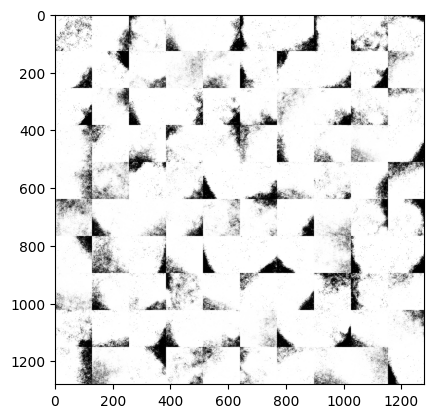

In [10]:
G.eval()
imshow(get_sample_image(G, N_NOISE), cmap='gray')


In [11]:
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')
